In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ofi = pd.read_csv('../data_cleaned/ofi_10_levels.csv')
OFI_values = ofi.drop(['mid_price_delta', 'time_bin', 'bin_label'], axis=1)

## Outlier detection with Isolation Forest and Linear Fit

In [3]:
from sklearn.ensemble import IsolationForest
import numpy as np

Fitting level 0
Fitting level 1
Fitting level 2
Fitting level 3
Fitting level 4
Fitting level 5


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

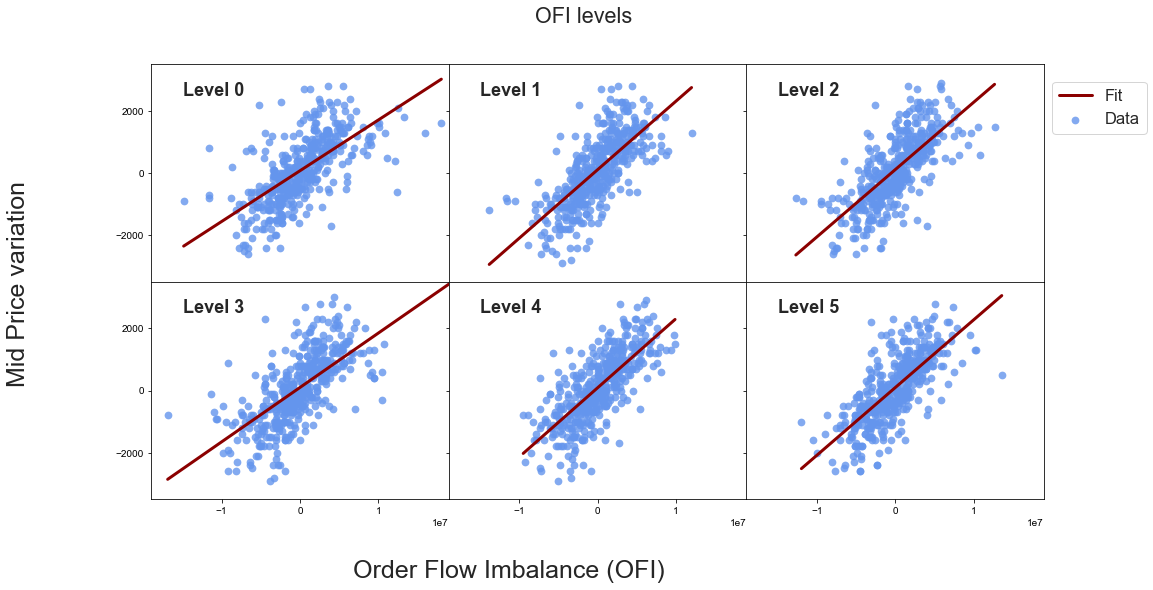

In [4]:
n_fit = 6
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
sns.set_theme(style='white', font_scale=1.5)
j=0
k=0
a_coeff, b_coeff, r2_scores, mse_scores  = [], [], [], []
for i in range(n_fit):
    print('Fitting level {}'.format(i))
    if i==3: 
        j=0
        k=1
    #removing outliers 
    trend_data = np.array([ofi['OFI_{}'.format(i)], ofi['mid_price_delta']], dtype=np.float64).T
    clf = IsolationForest(n_estimators=100)
    clf.fit(trend_data)   
    outliers = [True if x==1 else False for x in clf.predict(trend_data)]
    trend_data=trend_data[outliers].T

    # linear fit
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    model=Ridge()
    model.fit(trend_data[0].reshape(-1,1),trend_data[1])
    a, b = model.coef_[0], model.intercept_
    a_coeff.append(a)
    b_coeff.append(b)
    # r2_score: proportion of the variation in the dependent 
    # variable that is predictable from the independent variable
    r2_scores.append((r2_score(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))))
    mse_scores.append((mean_squared_error(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))))

    #plot
    predicted=[a*x+b for x in trend_data[0]]
    sns.scatterplot(x=trend_data[0], y=trend_data[1], ax=ax[k,j], \
                    s=60, marker='o', color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
    g=sns.lineplot(x=trend_data[0], y=predicted, ax=ax[k,j], lw=3, color='darkred', label='Fit')

    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if k!=0 and j!=0: ax[k,j].get_legend().remove()
    ax[k,j].set_xlabel('')
    ax[k,j].set_ylabel('')
    ax[k,j].set_xlim(-1.9e7, 1.9e7)
    ax[k,j].set_ylim(-3500, 3500)
    ax[k,j].text(-1.5e7, 2500, 'Level {}'.format(i), weight='bold')
    j+=1

#Options for the plot
fig.suptitle('OFI levels')
ax[0,0].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[0,0].set_xticklabels([])
ax[0,1].set_yticklabels('')
ax[1,1].set_yticklabels('')
ax[1,2].set_yticklabels('')
ax[0,2].set_yticklabels('')

fig.text(0, 0.5, 'Mid Price variation', rotation=90, va='center', fontsize=25)
fig.text(0.3, 0, 'Order Flow Imbalance (OFI) ', va='center', fontsize=25)
fig.subplots_adjust(hspace=.0, wspace=0.)

#output
import os 
if os.path.isdir('../figures')==False:
    os.mkdir('../figures')
fig.savefig('../figures/OFI_levels_fit.png', bbox_inches='tight')

#results
from IPython.display import display, Math
for i in range(n_fit): 
    display(Math(r'Level \,\,{} \quad \quad  \Delta \overline P = {:.4f}\,\, OFI_{} + {:.4f}'.format(i, a_coeff[i], i, b_coeff[i])+
            '\quad R^2 = {:.2f}, \quad MSE= {:.2f}'.format(r2_scores[i], mse_scores[i])))

### Multi dimensional linear fit

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0.5, 0, 'linear combination of OFI')

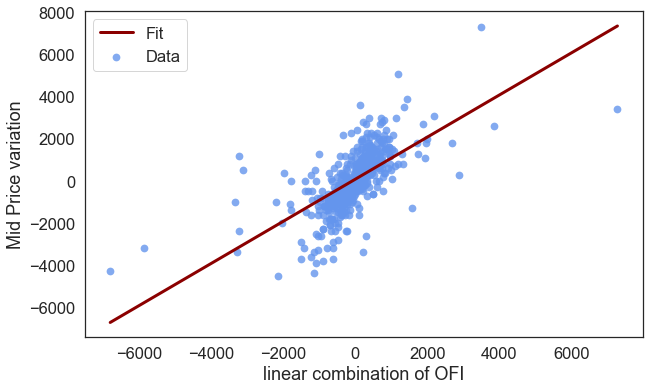

In [5]:
mid_price_delta = ofi['mid_price_delta']

# linear regression with sklearn
model=Ridge()
model.fit(OFI_values, mid_price_delta)
betas, alpha = model.coef_, model.intercept_
r2_scores=r2_score(mid_price_delta, model.predict(OFI_values))
mse_scores=mean_squared_error(mid_price_delta, model.predict(OFI_values))

display(Math(r'\Delta \overline P = \alpha+ \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}, \quad MSE= {:.2f}'.format(r2_scores, mse_scores)))

def linear_combination(weights, data):
        """
        args:
            weights (list or np.array): list of weights
            data (list or np.array): list of OFI
        returns:
            linear combination of data
        """
        return sum([w*d for w,d in zip(weights, data)])


#linear regression with direct optimization



sns.set_theme(style='white', font_scale=1.5)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
new_feature = [linear_combination(betas, OFI_values.iloc[i,:]) for i in range(len(OFI_values))]
sns.scatterplot(x=new_feature, y=mid_price_delta, ax=ax, s=60, marker='o', 
                color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
sns.lineplot(x=new_feature, y=alpha+new_feature, ax=ax, lw=3, color='darkred', label='Fit')
ax.set_ylabel('Mid Price variation')
ax.set_xlabel('linear combination of OFI')

## PCA and correlations

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(634.1681818181817, 0.5, 'Explained variance')

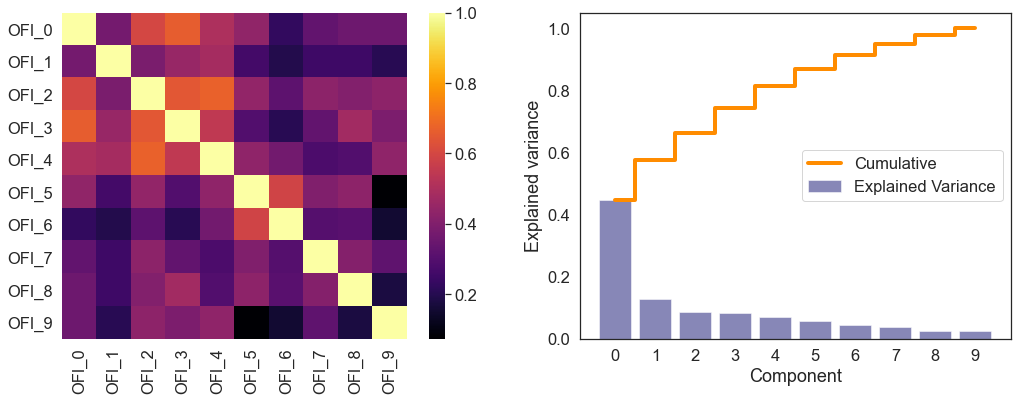

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled = scaler.fit_transform(OFI_values) 
pca = PCA(n_components=None)
pca.fit(scaled)
new_ofi = pca.transform(scaled)

sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
explained_var = pca.explained_variance_ratio_
fig, ax = plt.subplots(1,2, figsize=(17,6))

sns.barplot(np.arange(len(explained_var)), explained_var, alpha=0.5, color = 'navy', ax=ax[1], label='Explained Variance')
ax[1].step(np.arange(len(explained_var)), np.cumsum(explained_var),\
         drawstyle='steps-pre', color='darkorange', lw=4, where = 'mid', label='Cumulative')
plt.legend(loc='center right')
sns.heatmap(OFI_values.corr(), cmap='inferno', fmt='.1f', ax=ax[0])#annot=True
ax[1].set_xlabel('Component')
ax[1].set_ylabel('Explained variance')

## Define a new feature as linear combination of different level OFI
Loss function optimizes the variance of mid price delta dìthat can be described by the new feature in a linear way.

In [7]:

def loss(weights, data_ofi, mid_price_delta):
    """
    args:
        weights: list of weights
        data_ofi: list of OFI
        mid_price_delta: list of mid price delta
    returns:
        loss of linear combination of data
    """

    if len(weights)!=len(data_ofi.columns):
        raise ValueError('weights and data_ofi.columns must have the same length')
    if len(data_ofi)!=len(mid_price_delta):
        raise ValueError('data_ofi and mid_price_delta must have the same length')

    new_feature = np.array([linear_combination(weights, data_ofi.iloc[i,:]) for i in range(len(data_ofi))])

    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(trend_data[0].reshape(-1,1), trend_data[1])
    r2 = r2_score(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))
    return -r2

In [8]:
from scipy.optimize import minimize
mid_price_delta = ofi['mid_price_delta']
r=minimize(loss, x0=np.random.uniform(size=10), args=(OFI_values, mid_price_delta), 
        method='cobyla', bounds=[(0, None) for i in range(10)], options={'disp': True})
print('Loss function optimum: {:.2f}'.format(-r.fun))

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/scipy/optimize/_minimize.py:541: RuntimeWarning: Method cobyla cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


Loss function optimum: 0.53


Text(0.5, 0, 'linear combination of OFI')

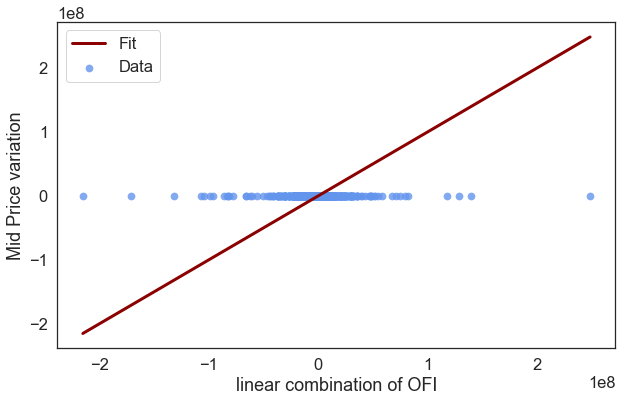

In [9]:
weights = r.x
new_feature = np.array([linear_combination(weights, OFI_values.iloc[i,:]) for i in range(len(OFI_values))])

sns.set_theme(style='white', font_scale=1.5)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
sns.scatterplot(x=new_feature, y=mid_price_delta, ax=ax, s=60, marker='o', 
                color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
sns.lineplot(x=new_feature, y=alpha+new_feature, ax=ax, lw=3, color='darkred', label='Fit')
ax.set_ylabel('Mid Price variation')
ax.set_xlabel('linear combination of OFI')


## Distributions

<AxesSubplot:xlabel='level', ylabel='OFI'>

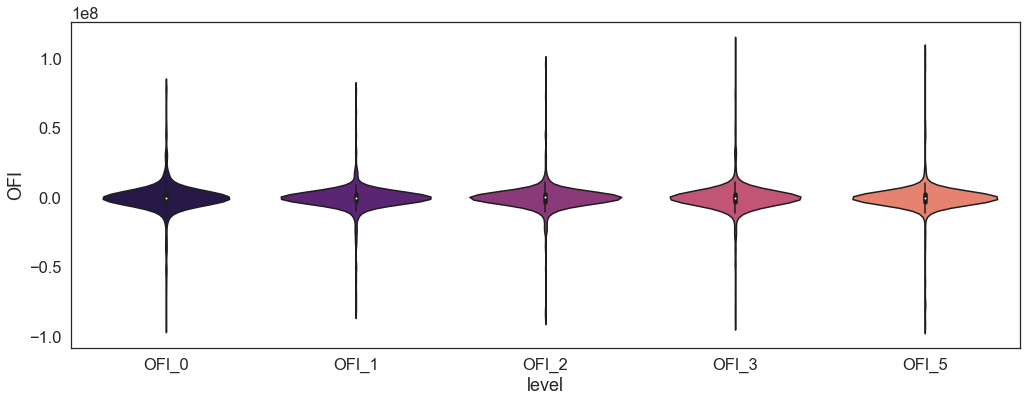

In [10]:
sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
fig, ax = plt.subplots(figsize=(17,6))
df_distr = OFI_values.copy()
df_distr = df_distr.drop(['OFI_9', 'OFI_8', 'OFI_7', 'OFI_6', 'OFI_4'], axis=1)
categorical_ofi = []
levels = []
for c in df_distr.columns:
    categorical_ofi = np.concatenate([categorical_ofi, OFI_values[c]])
    levels = np.concatenate([levels, np.repeat(c, OFI_values.shape[0])])
cat_ofi = pd.DataFrame({'OFI':categorical_ofi, 'level':levels})

sns.violinplot(data=cat_ofi, x='level',y='OFI', ax=ax)


## Multivariate Time Series Forecasting with LSTMs